In [1]:
import pyemu
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import shutil
import numpy as np
import sys

In [2]:
sys.path.insert(1, 'D:/spark/gits/apexmf')

In [3]:
from apexmf import apexmf_pst_viz
from apexmf.salt.salt_handler import SaltAnalysis
from apexmf.salt.analyzer import SaltAnalysis, SaltViz, get_stats

In [4]:
wd = "D:/spark/animas_amrs"
os.chdir(wd)

In [5]:
t_d = os.path.join(wd, "ies_template_pp")

In [10]:
# test run
pyemu.os_utils.run("pestpp-ies animas_amrs_pp_pre_rw_init.pst",cwd=t_d)

In [11]:
# reweight
pst = pyemu.Pst(os.path.join(t_d,'animas_amrs_pp_pre_rw_init.pst'))
pst.phi


3865609429942.241

# Reweight

In [12]:
balanced_groups = {grp:100000 for grp in pst.nnz_obs_groups}
# print(pst.phi) #assumes "my.res" is colocated with "my.pst"
pst.adjust_weights(obsgrp_dict=balanced_groups)

In [13]:
obs = pst.observation_data.copy()
obs.to_csv('test_obs.csv')

In [62]:
pst.write(os.path.join(t_d,'animas_amrs_pp_rw_init.pst'))

noptmax:0, npar_adj:335, nnz_obs:2734


# Prior

In [ ]:
'''
pst.pestpp_options['ies_num_reals'] = 100
pst.control_data.noptmax = -1
pst.write(os.path.join(template_ws,"animas_amrs_pp_rw_prior.pst"))
'''

In [6]:
num_workers = psutil.cpu_count(logical=False)

In [7]:
m_d = os.path.join('main_diagonal_pp_rw_prior_mc')

In [8]:
pyemu.os_utils.start_workers(t_d, # the folder which contains the "template" PEST dataset
                            'pestpp-ies', #the PEST software version we want to run
                            'animas_amrs_pp_rw_prior.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

In [9]:
pst = pyemu.Pst(os.path.join(m_d,'animas_amrs_pp_rw_prior.pst'))

In [10]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"animas_amrs_pp_rw_prior.0.obs.csv")
    )
# pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"animas_amrs_rw_pp.{0}.obs.csv".format(pst.control_data.noptmax)))


<Figure size 800x1050 with 0 Axes>

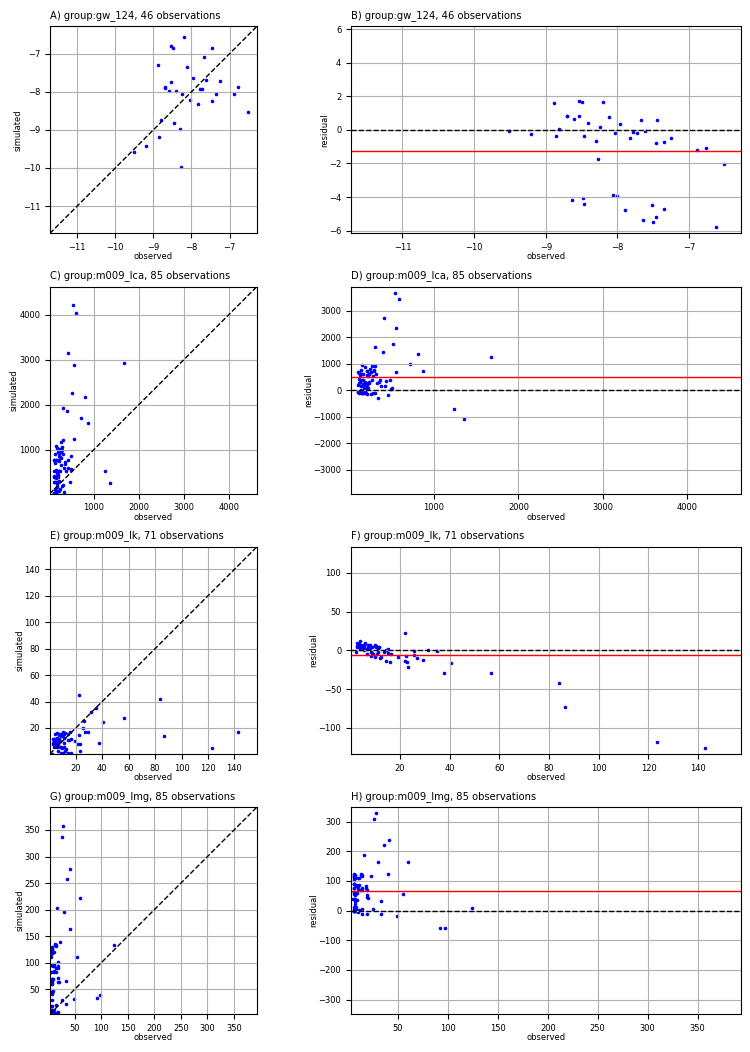

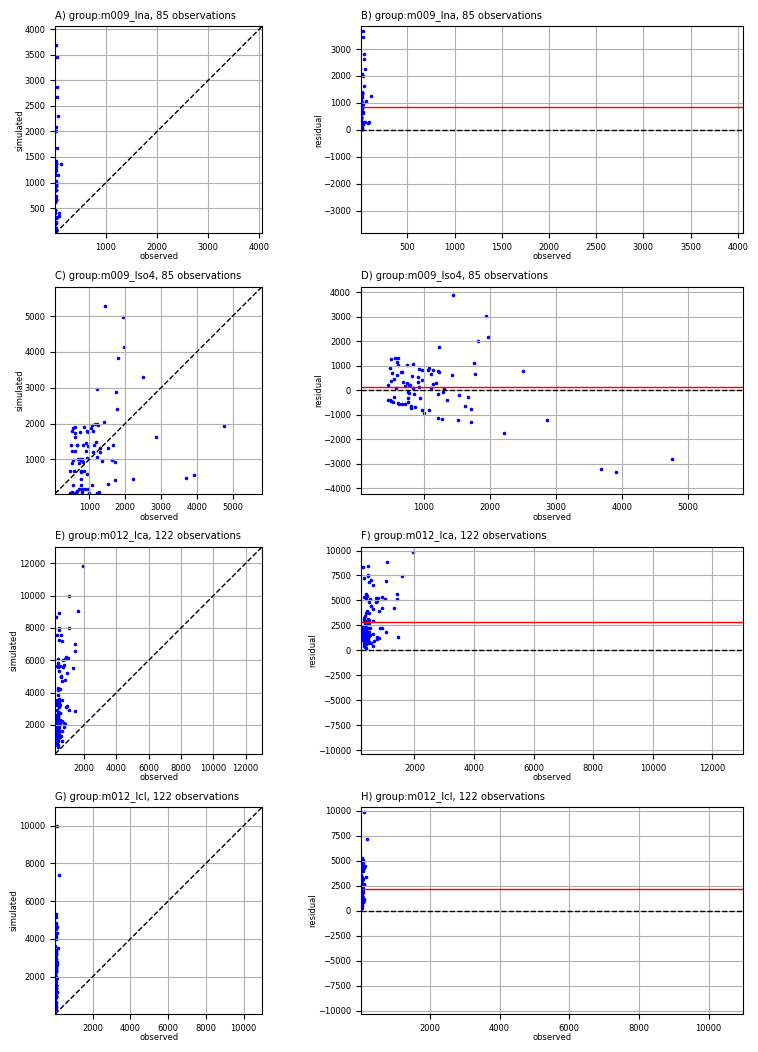

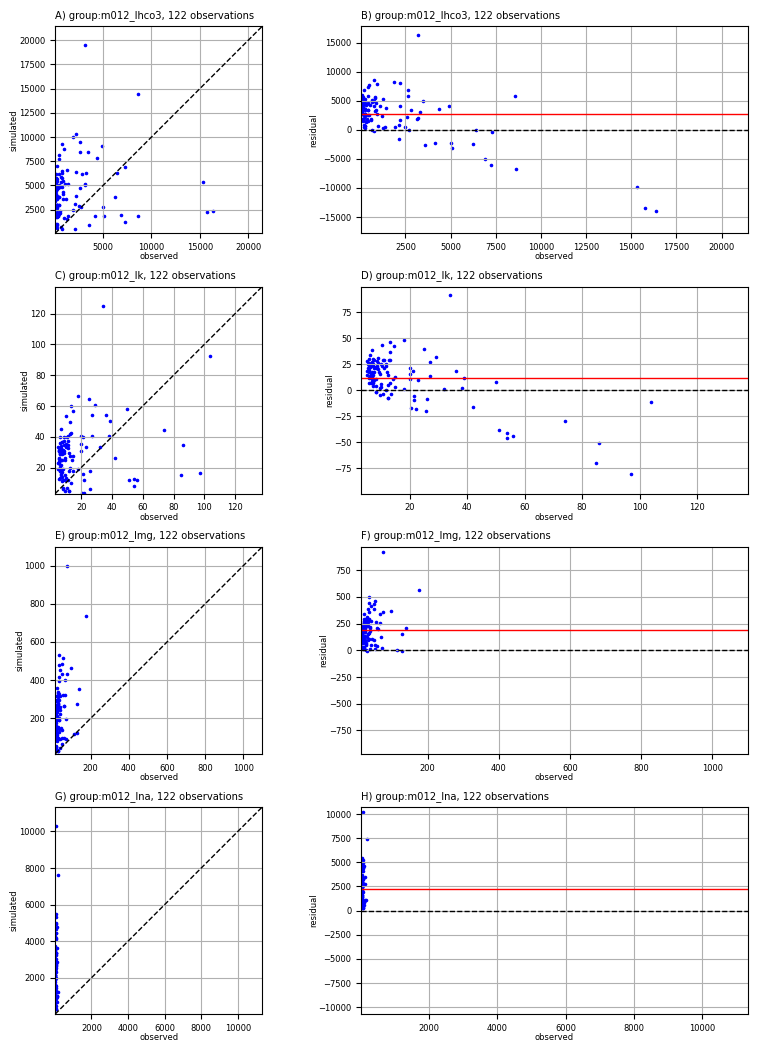

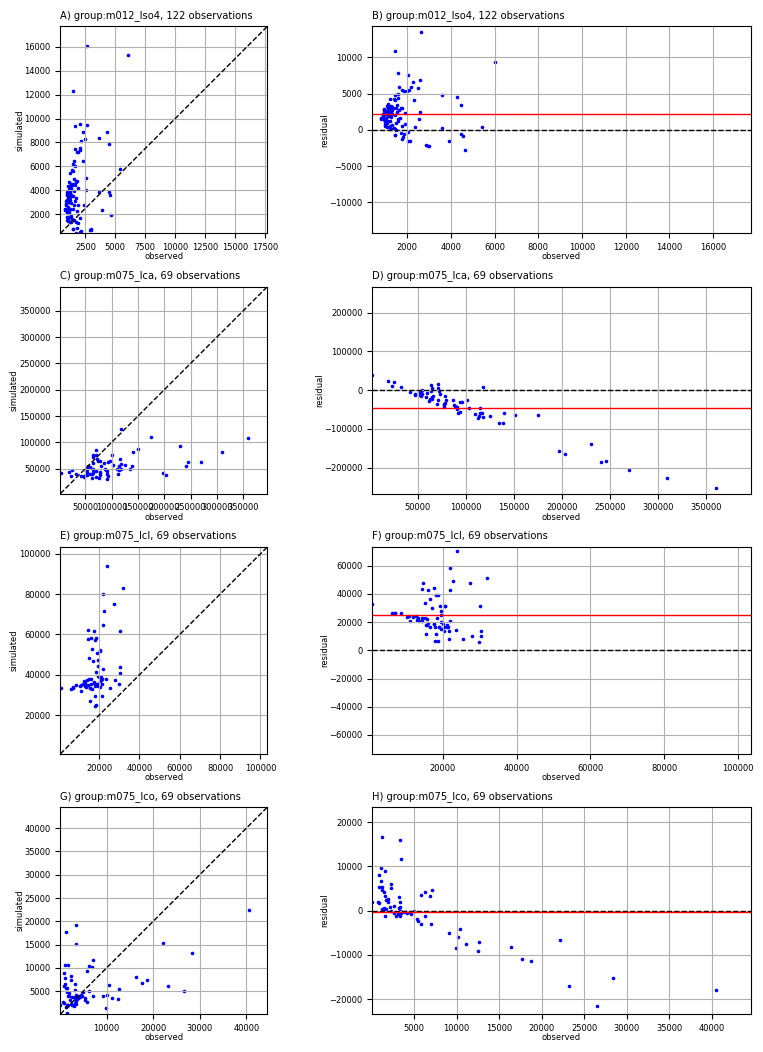

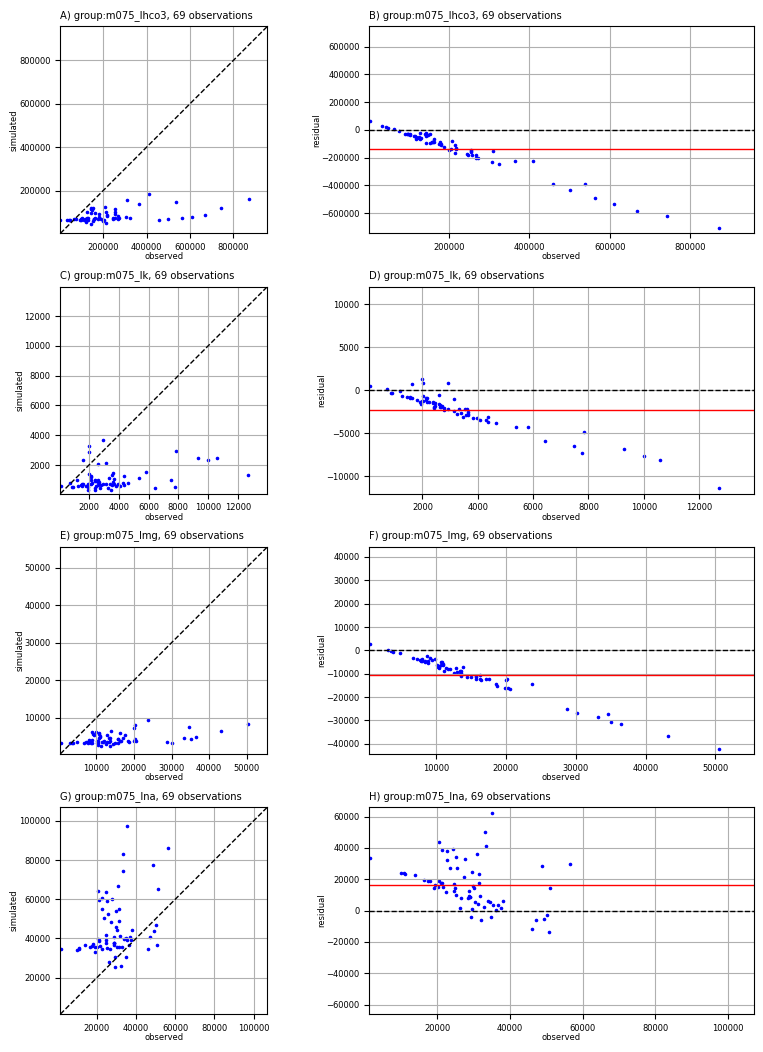

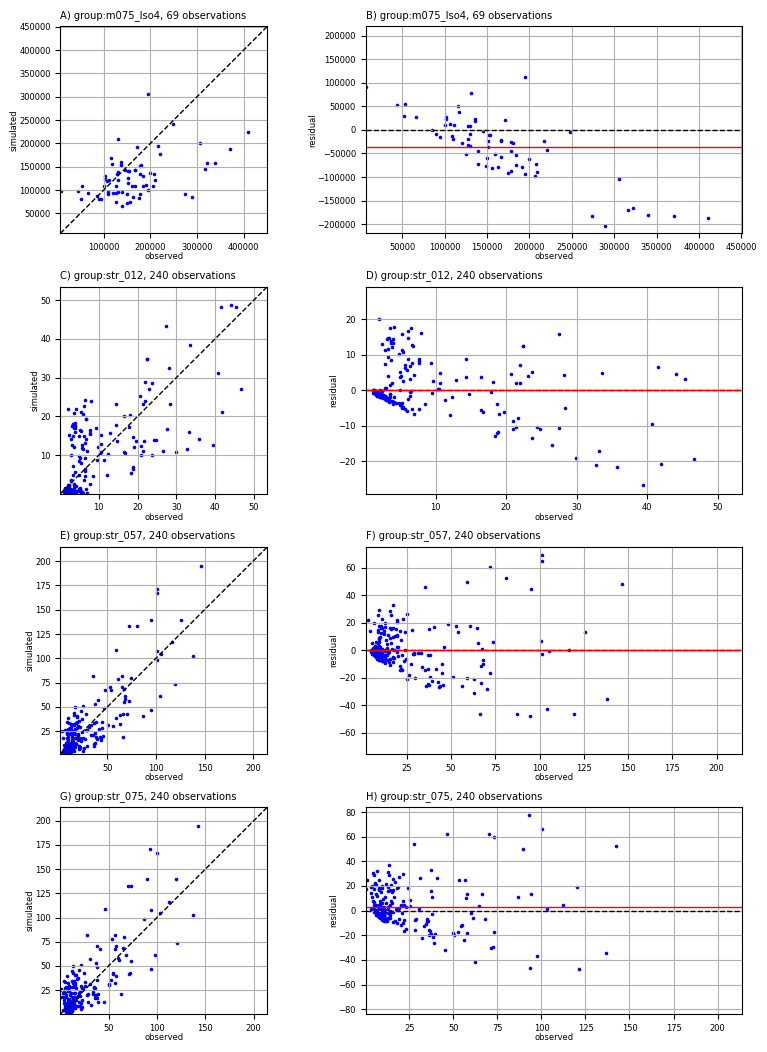

In [11]:
pyemu.plot_utils.res_1to1(pst);

In [13]:
def plot_tseries_prior_ensembles(pr_oe, dot=True):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # --- time control ---
    time_col = []
    for i in range(len(obs)):
        if obs.iloc[i, 0][0] == "g":
            time_col.append(obs.iloc[i, 0][-8:])
        else:
            time_col.append(obs.iloc[i, 0][-6:])
    obs['time'] = time_col
    # ---------------------
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(10,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.2) for i in pr_oe.index]
            # plot posterior
#             [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
#             [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig    

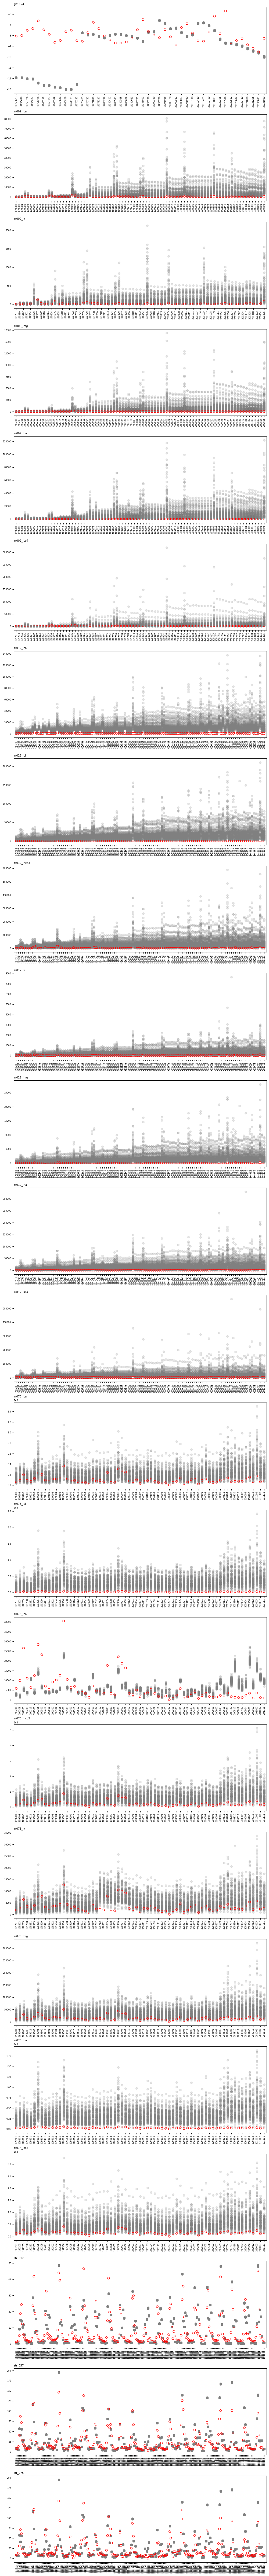

In [14]:
fig = plot_tseries_prior_ensembles(pr_oe, dot=True)

# Posterior

In [7]:
os.getcwd()

'D:\\spark\\animas_amrs'

In [8]:
m_d = os.path.join('main_ies_1_pp_rw_ies_init')

In [9]:
pyemu.os_utils.start_workers(t_d, # the folder which contains the "template" PEST dataset
                            'pestpp-ies', #the PEST software version we want to run
                            'animas_amrs_pp_rw_ies_init.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

In [12]:
pst = pyemu.Pst(os.path.join(m_d,'animas_amrs_pp_rw_ies_init.pst'))

In [13]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"animas_amrs_pp_rw_ies_init.0.obs.csv")
    )
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"animas_amrs_pp_rw_ies_init.{0}.obs.csv".format(pst.control_data.noptmax)))


<Figure size 800x1050 with 0 Axes>

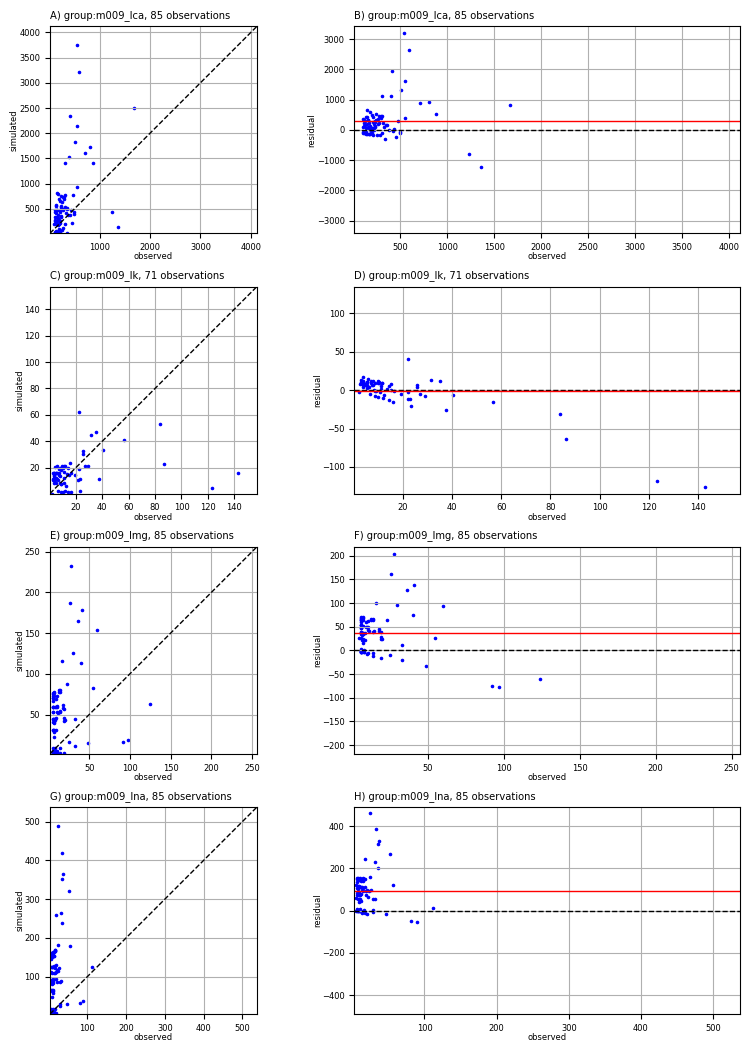

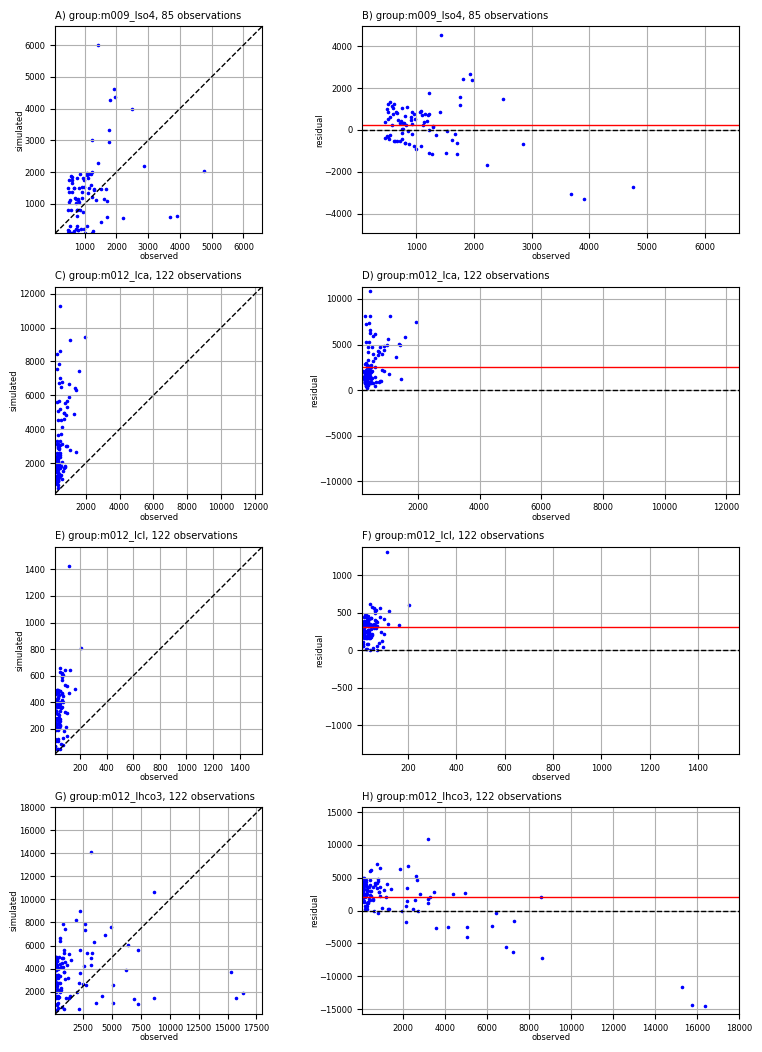

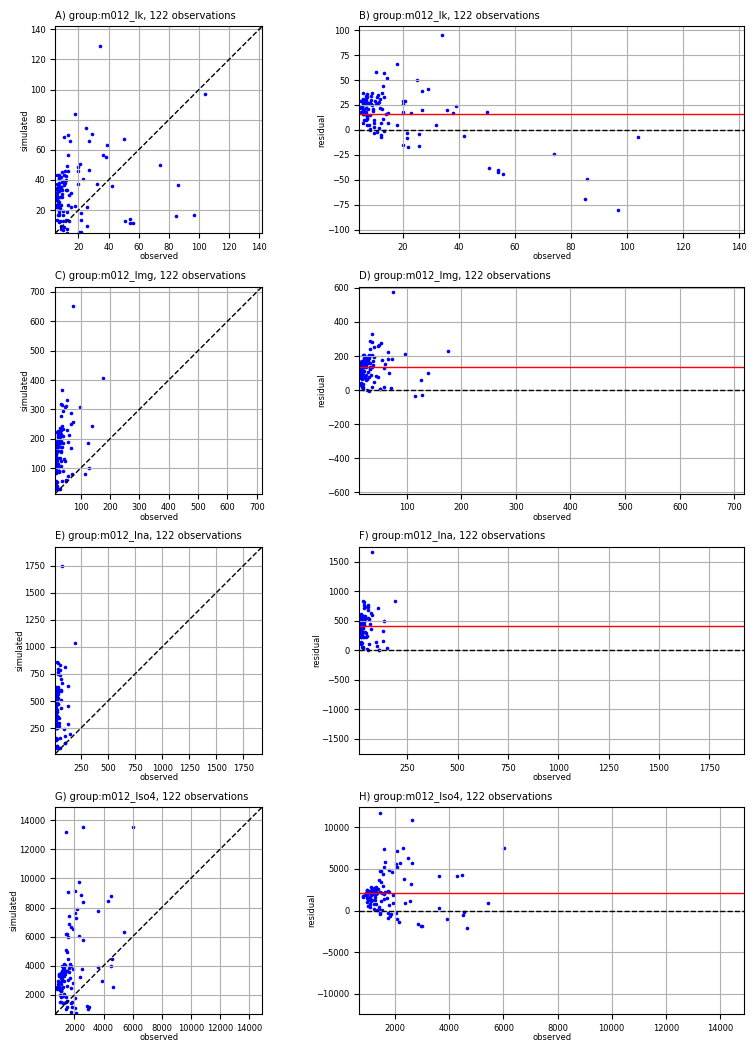

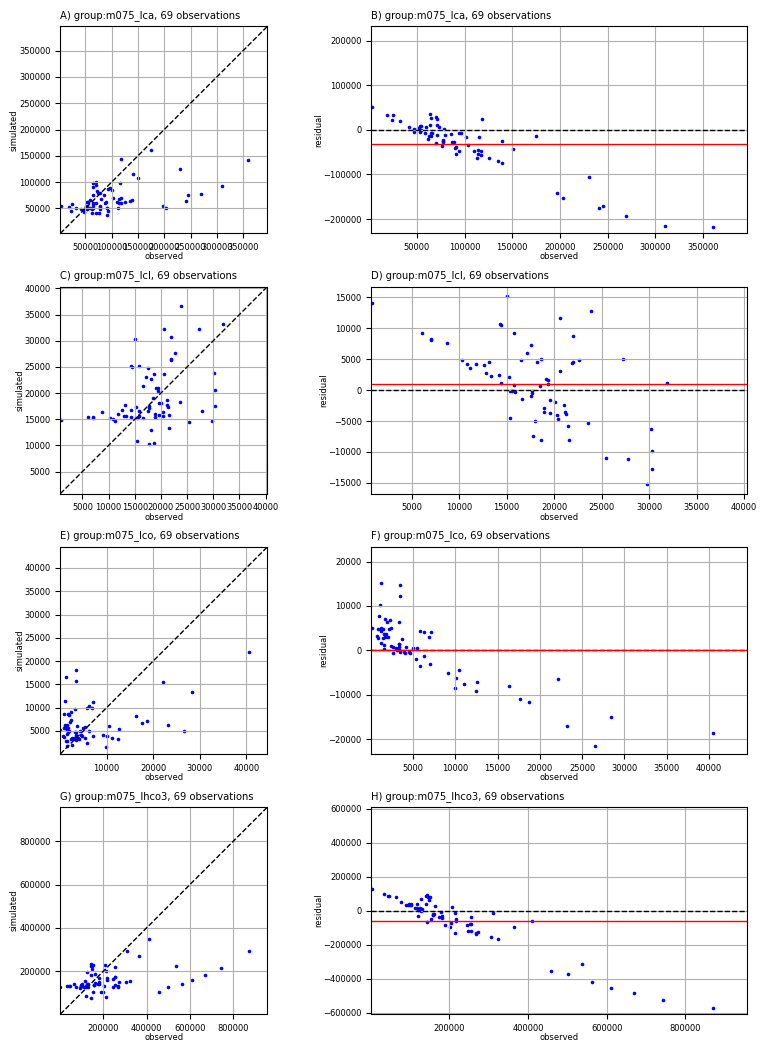

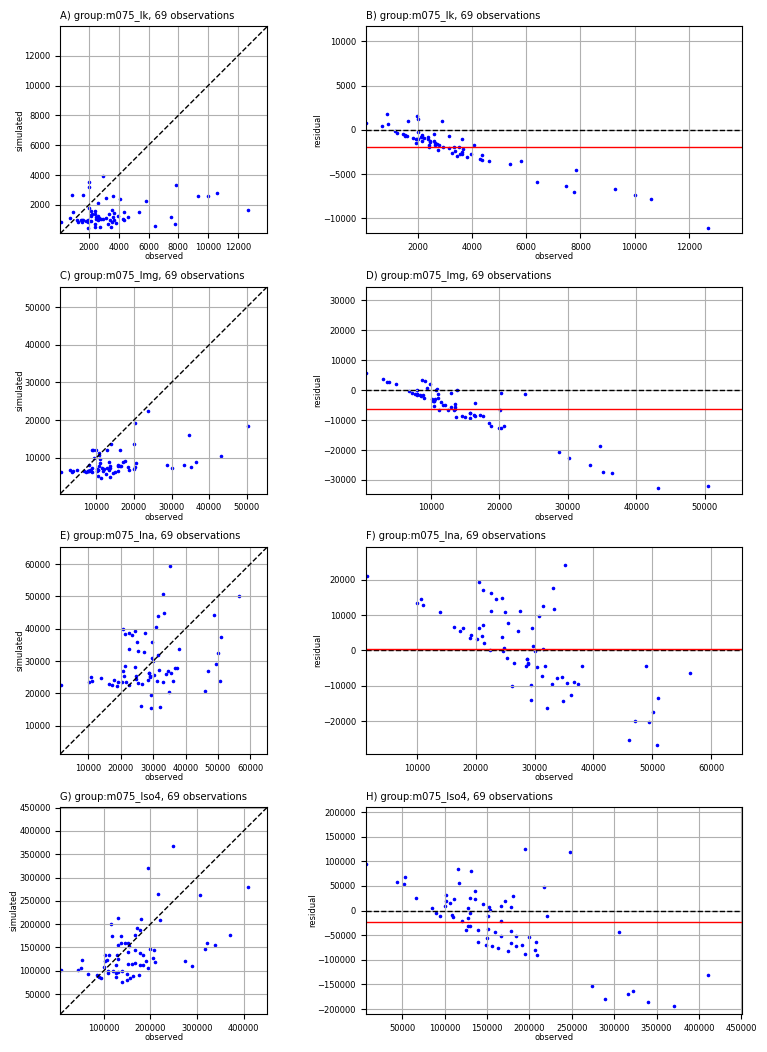

In [14]:
pyemu.plot_utils.res_1to1(pst);

In [17]:
pt_oe.phi_vector

real_name
1       1.284611e+06
2       1.384447e+06
3       1.242169e+06
4       1.384215e+06
6       1.375282e+06
            ...     
293     1.319026e+06
294     1.382100e+06
296     1.325206e+06
297     1.318802e+06
base    1.449518e+06
Length: 197, dtype: float64

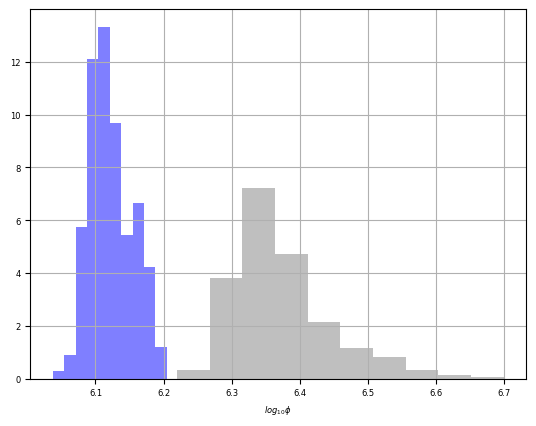

In [16]:
fig,ax = plt.subplots(1,1)
pr_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="0.5",ec="none",alpha=0.5,density=True)
pt_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="b",ec="none",alpha=0.5,density=True)
_ = ax.set_xlabel("$log_{10}\\phi$")

In [18]:
def plot_tseries_ensembles(
                    pr_oe, pt_oe, dot=True,
#                     onames=["hds","sfr"]
                    ):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    time_col = []
    for i in range(len(obs)):
        time_col.append(obs.iloc[i, 0][-6:])
    obs.time = time_col
#     # onames provided in oname argument
#     obs = obs.loc[obs.oname.apply(lambda x: x in onames)]
    # only non-zero observations
#     obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # make a plot
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(10,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig

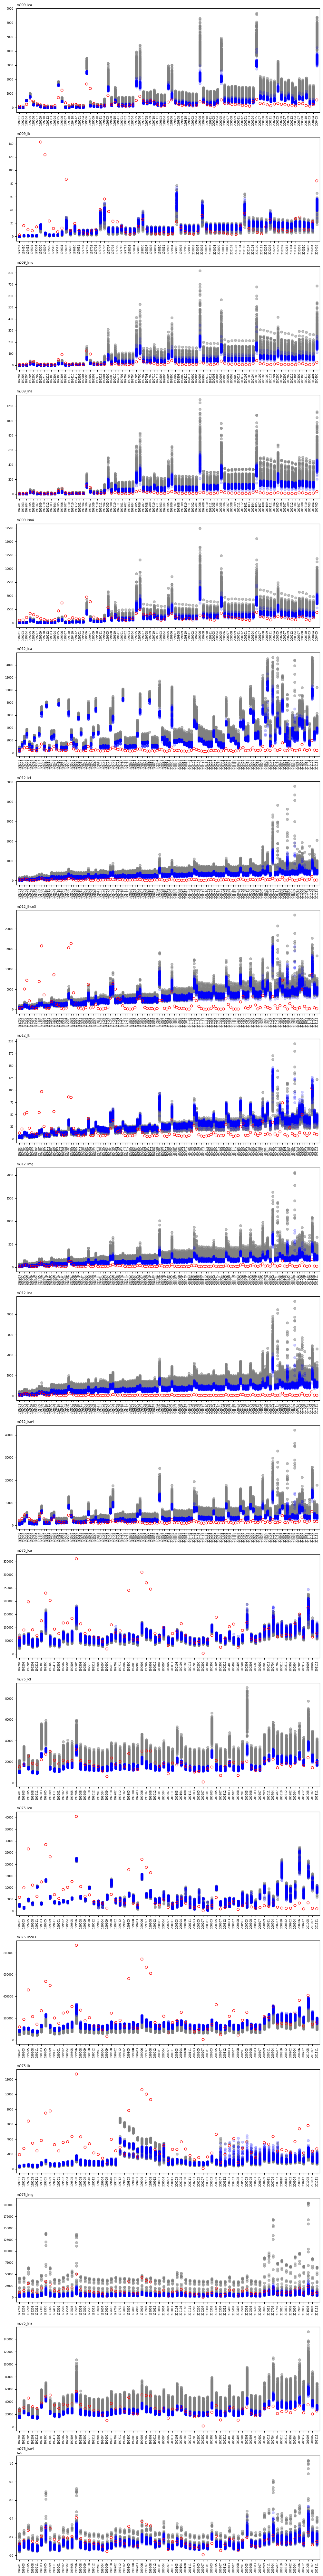

In [19]:
fig = plot_tseries_ensembles(pr_oe, pt_oe, dot=True)

In [26]:
os.getcwd()

'D:\\spark\\animas_amrs'

In [27]:
pst.parrep(parfile=os.path.join(m_d, 'animas_amrs_pp_rw_ies.7.base.par'))

Updating parameter values from main_ies_1_pp_rw_ies\animas_amrs_pp_rw_ies.7.base.par
parrep: updating noptmax to 0


In [28]:
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)

In [29]:
m_d

'main_ies_1_pp_rw_ies'

In [31]:
# run the model forward run; this applies all the multipler paarameters, executes MODFLOW6 and MODPATH7 and then postprocess observations
os.chdir(m_d)
pyemu.os_utils.run('python salt_forward_run.py')

In [32]:
os.getcwd()

'D:\\spark\\animas_amrs\\main_ies_1_pp_rw_ies'

In [33]:
def salt_viz(model, salt_df, subs):
    for i in subs:
        print(f"{'= = '*3}sub{i:03d} {'= = '*3}")
        sim_df = model.read_salt_sim_cha(salt_df, i, sim_start, cal_start, cal_end).resample('M').mean()
        obd_df = model.read_salt_obd_cha(i, time_step='mon')
        obd_df = obd_df[~obd_df.index.duplicated(keep='first')]    
        for o in obd_df.columns:
            comdf = model.sim_obd_df(sim_df, o, obd_df, o)
            print(o)
            print(get_stats(comdf['1/1/1992':'12/31/2011']))
            fig, ax = plt.subplots(1, 2, figsize=(12, 2), gridspec_kw={'width_ratios': [6, 1]})
            SaltViz(comdf['1/1/1992':'12/31/2011']).hydro_sim_obd02(ax[0])
            SaltViz(comdf['1/1/1992':'12/31/2011']).reg_line02(ax[1])
            fig.tight_layout()
            plt.show()

In [35]:
m_test = SaltAnalysis(os.getcwd())
salt_test = m_test.load_salt_cha_result()
sim_start = '1/1/1987'
cal_start = '1/1/1992'
cal_end = '12/31/2011'

= = = = = = sub075 = = = = = = 
load_so4
(-0.1287, 79735.2697, -24.9992, 0.2534)


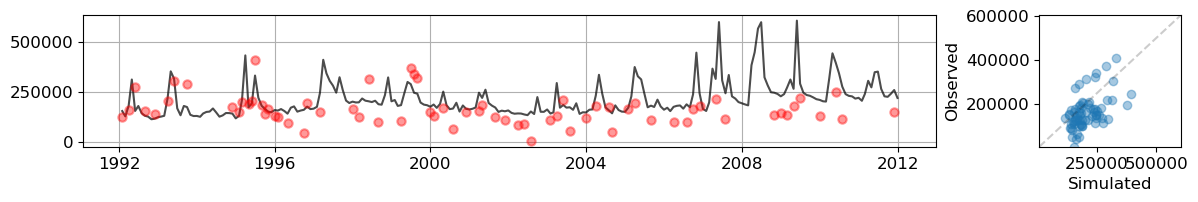

load_na
(-5.1844, 25865.1111, -76.1559, 0.2174)


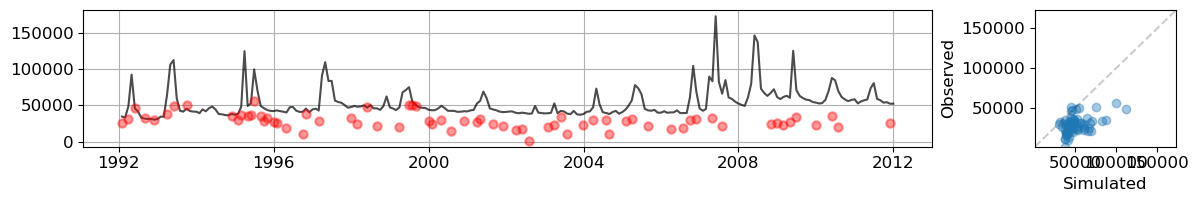

load_k
(-0.0169, 2393.4497, -18.8718, 0.1524)


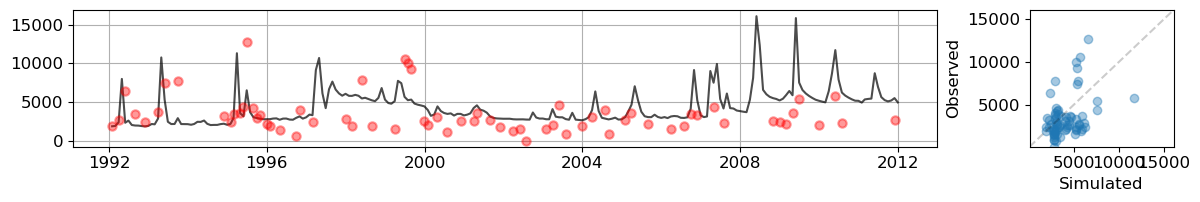

load_mg
(0.1345, 8650.4008, -20.853, 0.2819)


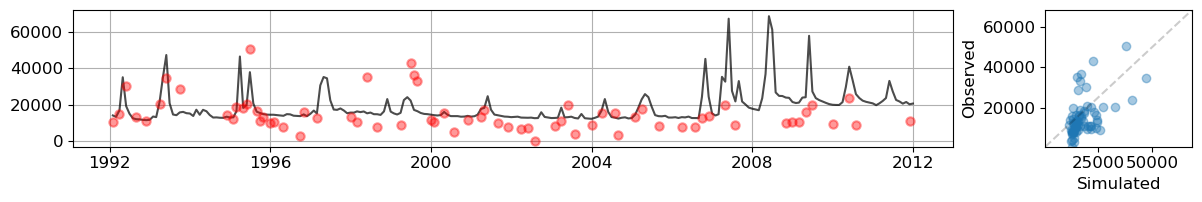

load_cl
(-20.6116, 27515.987, -138.1997, 0.1686)


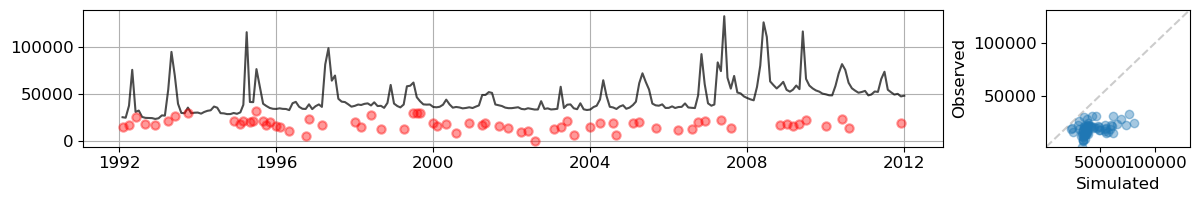

load_co3
(0.1519, 6918.5828, 5.1472, 0.1796)


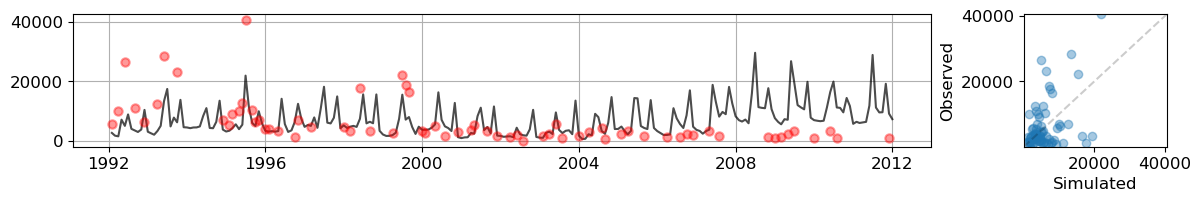

load_ca
(0.2447, 58303.9701, -11.6514, 0.2753)


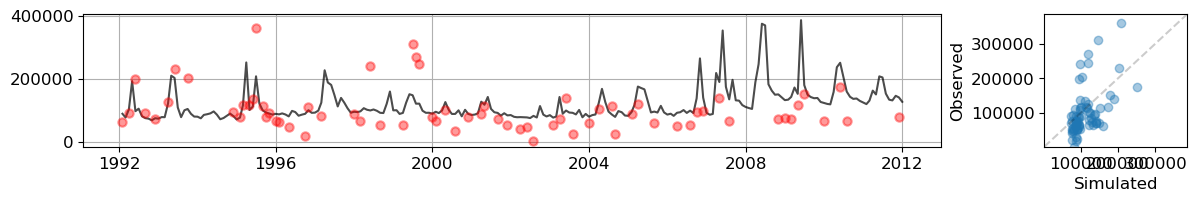

load_hco3
(0.0249, 165591.0474, -36.7416, 0.265)


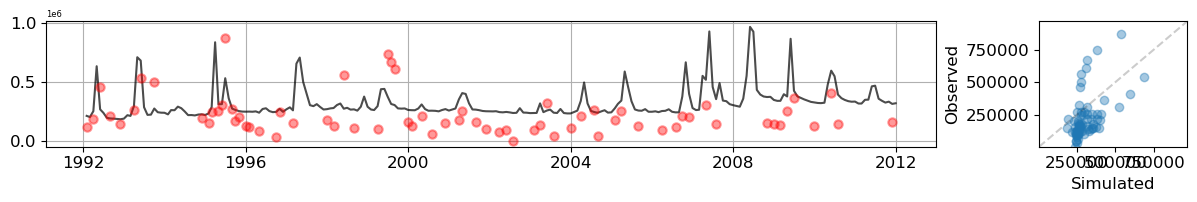

In [41]:
salt_viz(m_test, salt_test, [75])

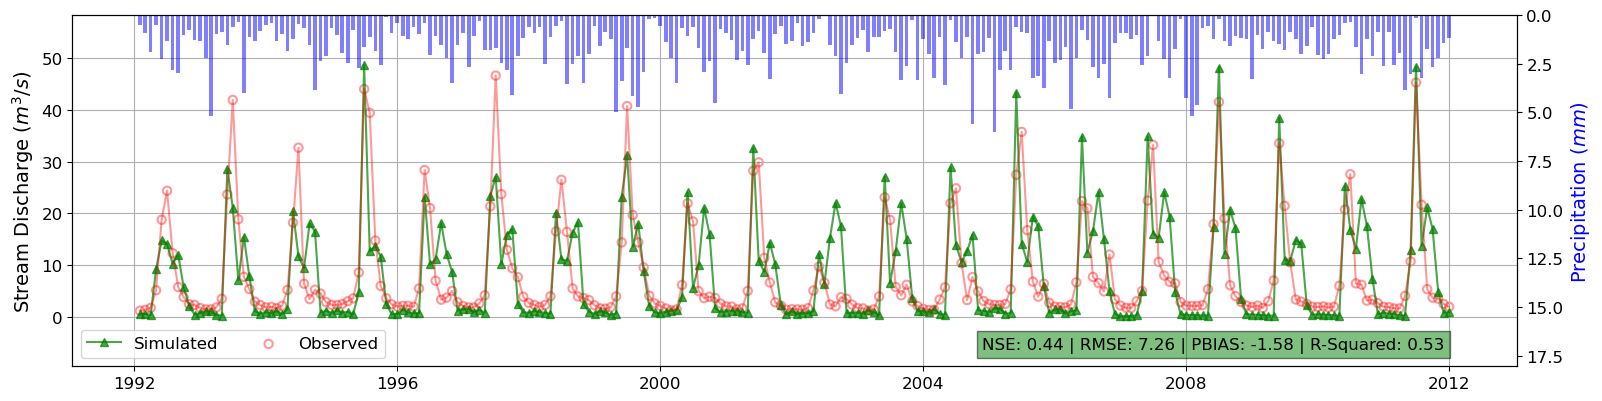

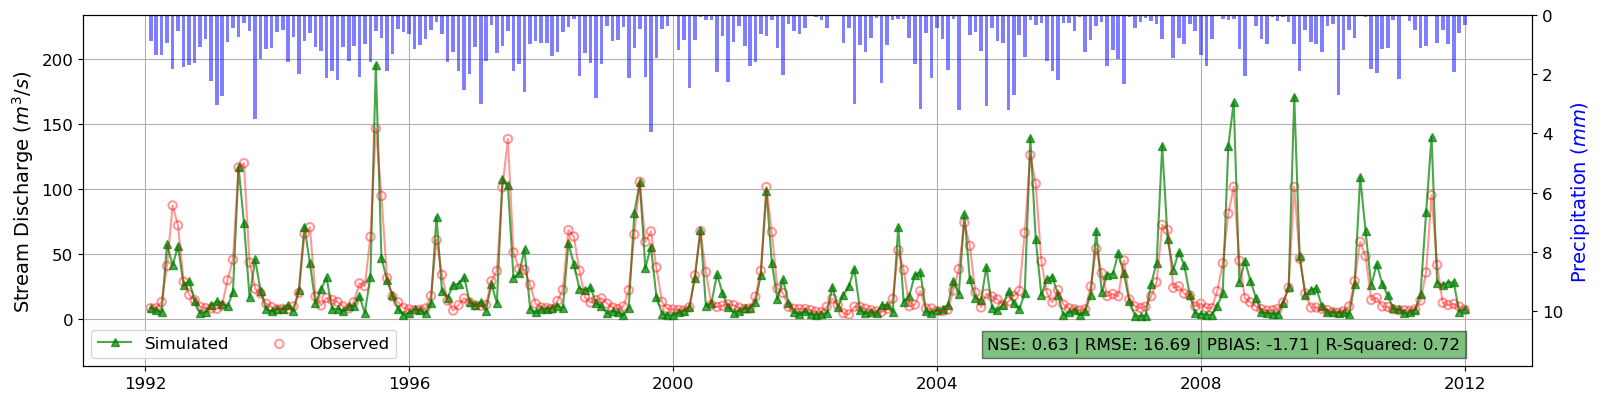

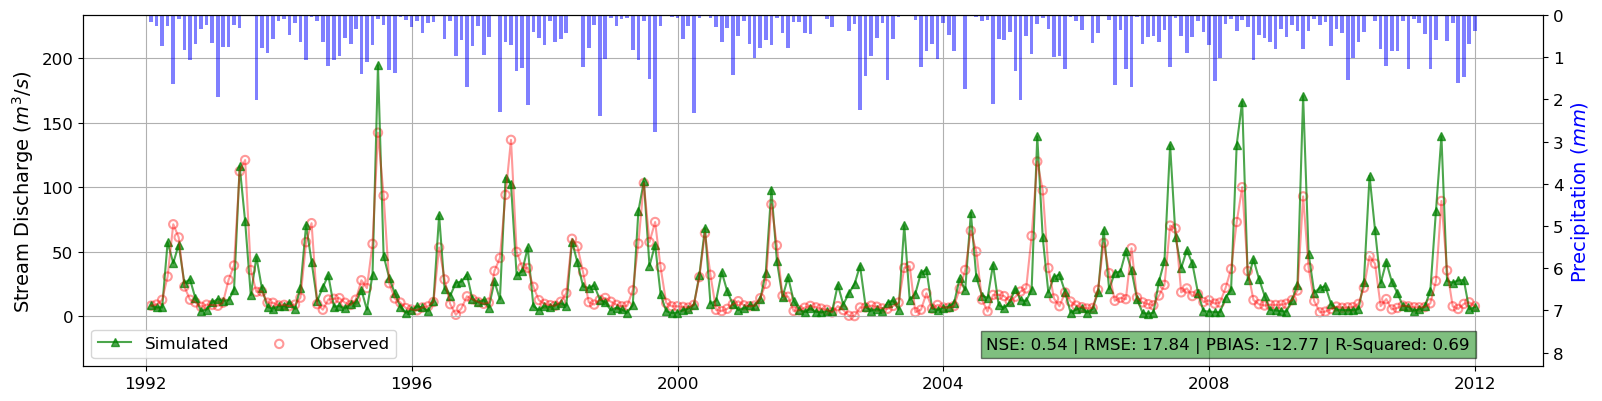

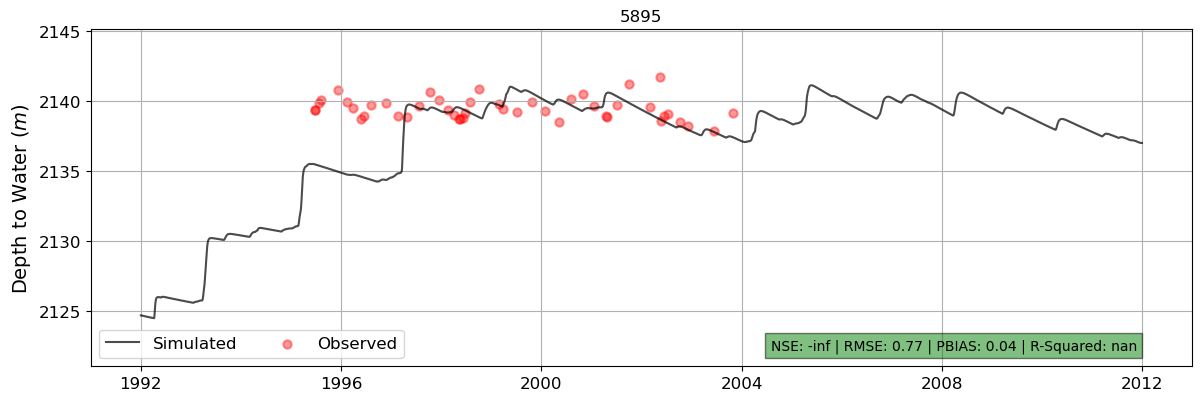

In [37]:
# wd = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/v02_calibrated'
os.chdir(t_d)
str_dic = {12:'str_012', 57:'str_057', 75:'str_075'}
for sim, obd in str_dic.items():
    pdf = apexmf_pst_viz.stf_df('SITE75.RCH', '1/1/1987', sim, obd, time_step='M')
    apexmf_pst_viz.stf_plot(pdf['1/1/1992':'12/31/2011'])
#     apexmf_pst_viz.str_plot(pdf['1/1/2010':'12/31/2019'])
mf_dic = {5895:'wt_gw_124'}
for sim, obd in mf_dic.items():
    mfdf = apexmf_pst_viz.wt_df('1/1/1987', sim, obd, prep_sub=75)
    # apexmf_pst_viz.wt_plot(mfdf['1/1/2010':'12/31/2019'])
    apexmf_pst_viz.wt_plot(mfdf['1/1/1992':'12/31/2011'])